In [1]:
#Data preparation
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset
dataframe = pd.read_csv('cleaned.csv')

# Exclude the unnecessary columns
columns_to_exclude = ['label', 'url', 'ssl_issuer', 'ssl_subject', 'ssl_not_before', 'ssl_not_after', 'domain']
X = dataframe.drop(columns=columns_to_exclude)
y = dataframe['label']

# Convert non-numeric columns in X to numeric using label encoding
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object':
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))
        label_encoders[column] = le

# Convert target variable y to numeric using label encoding if necessary
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y.astype(str))

X['url'] = dataframe['url']  # Keep the URL column for printing purposes
X_for_analysis = X.drop(columns=['url'])  # Drop the URL column for analysis


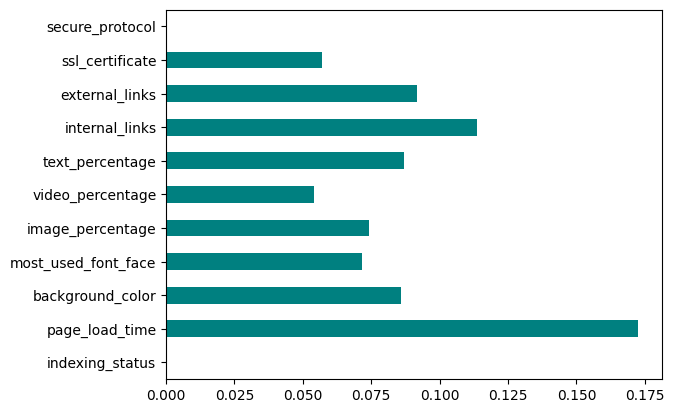

In [2]:
# Information Gain

%matplotlib inline

from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt


importances = mutual_info_classif(X_for_analysis, y)
feat_importances = pd.Series(importances, X_for_analysis.columns)
feat_importances.plot(kind='barh', color='teal')
plt.show()


In [3]:
#Chi-square Test

from sklearn.feature_selection import SelectKBest, chi2

X_cat = X_for_analysis.astype(int)
chi2_features = SelectKBest(chi2, k=5)
X_kbest_features = chi2_features.fit_transform(X_cat, y)

print('Original feature number:', X_cat.shape[1])
print('Reduced feature number:', X_kbest_features.shape[1])
print('Selected features:', X_cat.columns[chi2_features.get_support()])


Original feature number: 11
Reduced feature number: 5
Selected features: Index(['page_load_time', 'background_color', 'text_percentage',
       'internal_links', 'external_links'],
      dtype='object')


In [4]:
#Fisher’s Score
%matplotlib inline

from skfeature.function.similarity_based import fisher_score

# Fisher’s Score
ranks = fisher_score.fisher_score(X_for_analysis.values, y)
feat_importances = pd.Series(ranks, X_for_analysis.columns)
feat_importances.plot(kind='barh', color='teal')
plt.show()


ModuleNotFoundError: No module named 'skfeature'

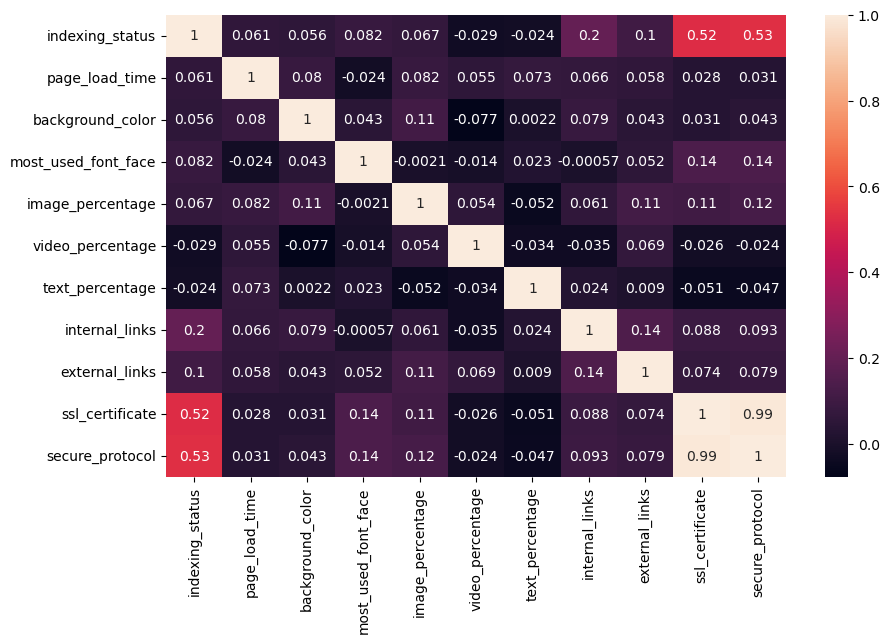

In [35]:
#Correlation Coefficient

import seaborn as sns

# Correlation matrix
cor = X_for_analysis.corr()

# Plotting Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(cor, annot=True)
plt.show()


In [39]:
# Variance Threshold
from sklearn.feature_selection import VarianceThreshold

v_threshold = VarianceThreshold(threshold=0)
v_threshold.fit(X_for_analysis)
support = v_threshold.get_support()
print(support)

selected_features = X_for_analysis.columns[support]
print('Selected features:', selected_features)

[ True  True  True  True  True  True  True  True  True  True  True]
Selected features: Index(['indexing_status', 'page_load_time', 'background_color',
       'most_used_font_face', 'image_percentage', 'video_percentage',
       'text_percentage', 'internal_links', 'external_links',
       'ssl_certificate', 'secure_protocol'],
      dtype='object')


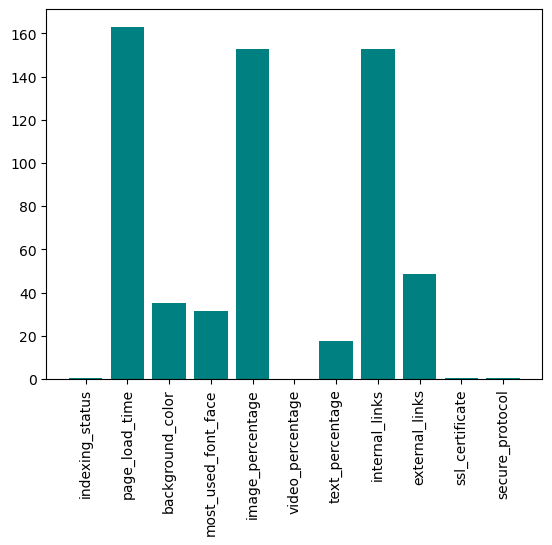

In [41]:
# Mean Absolute Difference (MAD)

import numpy as np

mean_abs_diff = np.sum(np.abs(X_for_analysis - np.mean(X_for_analysis, axis=0)), axis=0) / X_for_analysis.shape[0]

# Plot the barchart
plt.bar(np.arange(X_for_analysis.shape[1]), mean_abs_diff, color='teal')
plt.xticks(np.arange(X_for_analysis.shape[1]), X_for_analysis.columns, rotation=90)
plt.show()


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS


# Load the dataset
df = pd.read_csv('cleaned.csv')

# Exclude the unnecessary columns
columns_to_exclude = ['label', 'url', 'ssl_issuer', 'ssl_subject', 'ssl_not_before', 'ssl_not_after', 'domain']
X = df.drop(columns=columns_to_exclude)
y = df['label']

# Convert non-numeric columns in X to numeric using label encoding
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object':
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))
        label_encoders[column] = le

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a RandomForestClassifier instance
model = RandomForestClassifier(random_state=42)

# Perform forward feature selection
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward')
sfs.fit(X_train, y_train)

# Get the selected features
selected_features_f = X_train.columns[sfs.get_support()]
print("Selected features_forward:", selected_features_f)

Selected features_forward: Index(['page_load_time', 'most_used_font_face', 'image_percentage',
       'video_percentage', 'text_percentage'],
      dtype='object')


In [6]:
sfsb = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward')
sfsb.fit(X_train, y_train)

selected_features_b = X_train.columns[sfsb.get_support()]
print("Selected features_backwards:", selected_features_b)

Selected features_backwards: Index(['page_load_time', 'background_color', 'most_used_font_face',
       'video_percentage', 'internal_links', 'external_links'],
      dtype='object')


In [7]:
# efs = EFS(RandomForestClassifier(),
#          min_features = 1,
#          max_features = X.shape[1],
#          scoring = 'accuracy',
#          cv = 2)
# efs = efs.fit(X_train,y_train)
# print('Best subset (indices):', efs.best_idx_)
# print('Best subset (corresponding names):', efs.best_feature_names_)
# print('Best CV score:', efs.best_score_)

from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score

# Initialize the classifier
clf = RandomForestClassifier()

# Initialize RFECV
rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='accuracy')

# Fit the model
rfecv.fit(X_train, y_train)

# Print the optimal number of features
print('Optimal number of features:', rfecv.n_features_)

# Print the selected features
print('Selected features:', X_train.columns[rfecv.support_])

# Evaluate the model on the test set using the selected features
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
print('Test accuracy:', accuracy_score(y_test, y_pred))

Optimal number of features: 11
Selected features: Index(['indexing_status', 'page_load_time', 'background_color',
       'most_used_font_face', 'image_percentage', 'video_percentage',
       'text_percentage', 'internal_links', 'external_links',
       'ssl_certificate', 'secure_protocol'],
      dtype='object')
Test accuracy: 0.3112244897959184


In [8]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

columns_to_exclude = ['url', 'ssl_issuer', 'ssl_subject', 'ssl_not_before', 'ssl_not_after', 'domain']
data = df.drop(columns=columns_to_exclude)


label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':  # Check if the column is of type 'object' (i.e., categorical)
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
        
# y = data['label']
label_encoders = {}

if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y.astype(str))
    label_encoders['label'] = le

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# print(y_train)

lasso = Lasso(alpha=1.0)

# Fit the model to the training data
# print(X_train)
# print(y_train)
# print(X_train)
# print(y_train)
lasso.fit(X_train, y_train)

# Get the coefficients of the features
lasso_coefficients = pd.Series(lasso.coef_, index=X.columns)

# Print the coefficients
print("Lasso coefficients:")
print(lasso_coefficients)

# Evaluate the model on the test set
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on the test set:", mse)

Lasso coefficients:
indexing_status        0.000000
page_load_time         0.000000
background_color       0.000000
most_used_font_face   -0.000000
image_percentage       0.000000
video_percentage       0.000000
text_percentage       -0.001394
internal_links         0.000779
external_links         0.002513
ssl_certificate       -0.000000
secure_protocol       -0.000000
dtype: float64
Mean Squared Error on the test set: 6.700255874424077


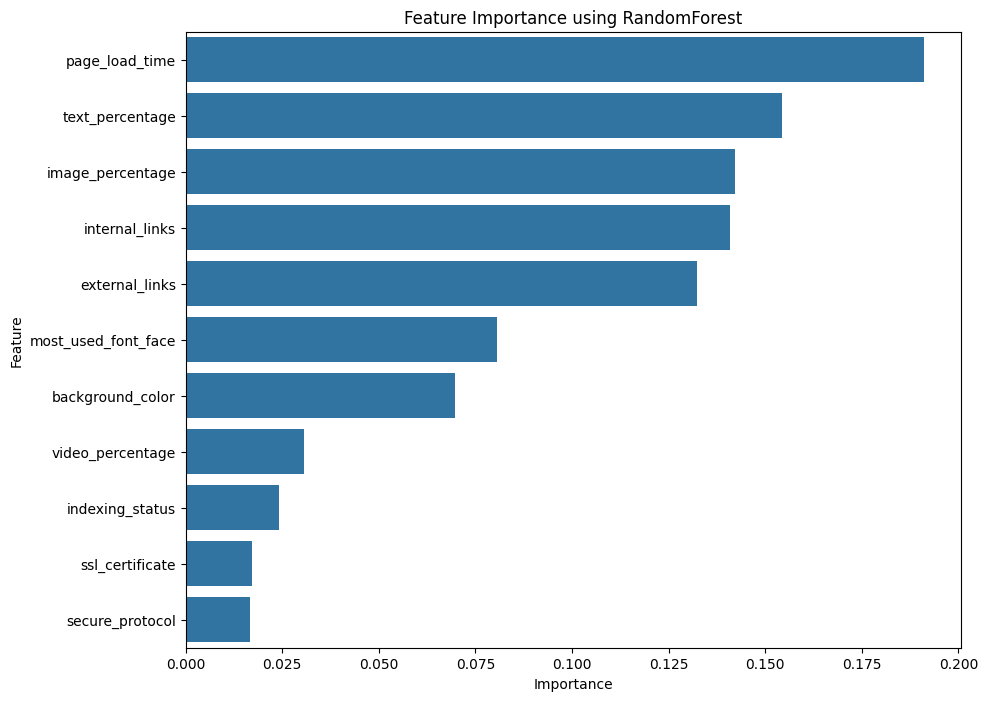

Feature importances:
                Feature  Importance
1        page_load_time    0.191027
6       text_percentage    0.154460
4      image_percentage    0.142124
7        internal_links    0.140979
8        external_links    0.132434
3   most_used_font_face    0.080613
2      background_color    0.069717
5      video_percentage    0.030706
0       indexing_status    0.024090
9       ssl_certificate    0.017199
10      secure_protocol    0.016649


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the RandomForest model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get the feature importances
importances = clf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance using RandomForest')
plt.show()

# Print the feature importances
print('Feature importances:')
print(feature_importances)

In [10]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# numeric_columns = ['page_load_time', 'image_percentage', 'video_percentage', 
#                    'text_percentage', 'internal_links', 'external_links']

# # Drop rows with missing values in the selected columns
# data_numeric = X[numeric_columns].dropna()

# print(data_numeric)
# # Standardize the data
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data_numeric)

# # Apply PCA
# pca = PCA(n_components=2)  # Let's reduce to 2 components for visualization
# principal_components = pca.fit_transform(data_scaled)

# # Create a DataFrame with the principal components
# pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# # Display the first few rows of the PCA results
# pca_df.head()

# # Convert non-numeric values to NaN and drop those rows
# data_numeric_cleaned = data_numeric.apply(pd.to_numeric, errors='coerce').dropna()

# # Standardize the cleaned data
# data_scaled_cleaned = scaler.fit_transform(data_numeric_cleaned)

# # Apply PCA again
# pca_cleaned = PCA(n_components=2)
# principal_components_cleaned = pca_cleaned.fit_transform(data_scaled_cleaned)

# # Create a DataFrame with the principal components
# pca_df_cleaned = pd.DataFrame(data=principal_components_cleaned, columns=['Principal Component 1', 'Principal Component 2'])

# # Display the first few rows of the cleaned PCA results
# print(pca_df_cleaned)



import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import numpy as np

# Separate features and handle categorical data
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Fit the preprocessor and PCA
preprocessed_data = preprocessor.fit_transform(df)
pca = PCA()
pca.fit(preprocessed_data)

# Get the feature names after one-hot encoding
feature_names = preprocessor.get_feature_names_out()

# Compute the total contribution of each feature across all principal components
# Sum the absolute values of the component weights for each feature
feature_importance = np.abs(pca.components_).sum(axis=0)

# Get the indices of the top 5 most important features
top_feature_indices = feature_importance.argsort()[-5:][::-1]

# Get the names of the top 5 most important features
top_features = [feature_names[i] for i in top_feature_indices]

# Print the top 5 features
print("Top 5 overall features after PCA:")
print(top_features)


TypeError: PCA only support sparse inputs with the "arpack" solver, while "auto" was passed. See TruncatedSVD for a possible alternative.

In [11]:
from boruta import BorutaPy

data_numeric = X[numeric_columns].apply(pd.to_numeric, errors='coerce').dropna()

# Define the target variable ('label' in this case) and the feature matrix
A = data_numeric
b = df['label'].dropna()  # Make sure the target variable doesn't have missing values

# Use a RandomForestClassifier as the estimator for Boruta
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)

# Initialize Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# Fit Boruta
boruta.fit(A.values, b.values)

# Print the selected features
selected_features = A.columns[boruta.support_].tolist()
print('Selected Features:', selected_features)

# Optionally, print the ranking of features
ranking = A.columns[boruta.ranking_].tolist()
print('Feature Ranking:', ranking)

NameError: name 'numeric_columns' is not defined